# Recommender Systems
## Writing an Algorithm for Recommending Movies with a Collaborative Filtering
In dit script probeer ik een algoritme te schrijven die de beoordeling van boeken gaat voorspellen voor mensen. Recommender Systems worden gebruikt door bedrijven zoals YouTube en Netflix om jou langer op hun platform te houden. Ook kan het gebruikt worden door online kledingwinkels die willen voorspellen welke kleding jij leuk vindt.

De dataset die wordt gebruikt is de [Book-Crossing database](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). Daarnaast gebruik ik de kennis die ik heb opgedaan vanuit dit [Towards Data Science](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b) artikel.


In [49]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from surprise import *
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.evaluate import accuracy

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
datadir = "data/BX-CSV-Dump/"
userFile = "BX-Users.csv"
booksFile = "BX-Books.csv"
ratingsFile = "BX-Book-Ratings.csv"

In [3]:
dfUsers = pd.read_csv(datadir + userFile, sep = ";", error_bad_lines=False, encoding="latin-1")
dfBooks = pd.read_csv(datadir + booksFile, sep = ";", error_bad_lines=False, encoding="latin-1")
dfRatings = pd.read_csv(datadir + ratingsFile, sep = ";", error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\winPython\python-3.7.0.amd64\lib\site-packages\IPython\core\interactive

In [4]:
dfUsers.columns = ['userID', 'Location', 'Age']
dfRatings.columns = ['userID', 'ISBN', 'bookRating']
df = pd.merge(dfUsers, dfRatings, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [5]:
data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Om te zien met wat voor data we te maken hebben, gaan we een mooie plot maken. Voor deze plots wordt `plotly` gebruikt. Deze plots zijn natuurlijk ook mogelijk met `matplotlib`, maar dit ziet er wat chiquer uit. In de bovenstaande plot is te zien dat de overgrote meerderheid van de ratings $0$ zijn. Daarnaast zijn de ratings scheef verdeeld tegenover de hoge kant. Dit is waarschijnlijk vanwege het feit dat goede boeken populairder worden dan slechte boeken. 

In [6]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In de volgende plot is een frequentie histogram gemaakt met de hoeveelheid ratings per boek. Hier is te zien dat de meeste boeken niet meer dan 10 ratings heeft gehad en weinig boeken hebben veel ratings. In de onderstaande tabel zie je zelfs dat de top 10 boeken kwa aantal ratings ook redelijk ver uit elkaar zitten. 

In [7]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

In [8]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Dezelfde grafieken kunnen we maken, maar dan vanuit de users kant. Een gelijke verdeling is te zien waarbij heel veel users niet veel ratings hebben gegeven en een paar users erg veel ratings hebben gegeven. De user met de meeste rating heeft ook bijna 2x zo veel ratings als de user daaropvolgend. 

In [9]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

Om de vergelijking gelijker te maken en potentiele ruis er uit te halen, filteren we de boeken en gebruikers op minimaal 50 ratings.

In [10]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


Om de data in te laden gebruiken we de `Reader` en `Dataset` class van surprise. Omdat we met pandas werken gebruiken we functie `load_from_df`. Deze wil een dataframe met 3 kolommen, namelijk:
- userID
- bookID (of ander productID)
- rating

Elke rij heeft daardoor een rating van een boek door een gebruiker. 

In [11]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [13]:
benchmark = []
algos = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]
pbarAlgo = tqdm(total = len(algos))
# Iterate over all algorithms
for algorithm in algos:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    pbarAlgo.update(1)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


test_rmse    fit_time  test_time
Algorithm                                        
BaselineOnly      3.380262    0.279239   0.461071
CoClustering      3.472942    3.213150   0.420105
SlopeOne          3.474631    0.926474   4.604438
KNNWithMeans      3.485252    1.383538   8.342215
KNNBaseline       3.493821    1.242280   7.207862
KNNWithZScore     3.505901    1.204634   6.585220
SVD               3.541939   13.270053   0.941133
KNNBasic          3.729414    1.271270   7.766211
SVDpp             3.799360  251.903785   6.786775
NMF               3.857894    9.312323   0.589994
NormalPredictor   4.673836    0.189224   0.436083

Volgens de tabel hierboven is `BaselineOnly` het beste model voor deze context. Om te testen, trainen en voorspellen gaan we dan ook dit algoritme gebruiken met ALS (Alternating Least Squares). Dit is een twee-staps optimalisatie algoritme ([lees hier meer](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)).

In [14]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.37882384, 3.3821016 , 3.36970174]),
 'fit_time': (0.200883150100708, 0.2248704433441162, 0.31381916999816895),
 'test_time': (0.6756124496459961, 0.6506268978118896, 0.7745580673217773)}

We gebruiken een train en testset om het model te trainen en te testen met andere data. Dit is belangrijk, anders heb je kans op overfitting zonder dat je het weet. 

In [25]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3449


3.3448722109001183

Om wat meer inzicht te krijgen in het model en de voorspellingen moeten we alle voorspellingen in een pandas dataframe zetten. 

In [26]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

De kolom `rui` is de daadwerkelijke rating en `est` is de geschatte rating. Het verschil hiertussen is de error (`err`). De kolommen `Iu` en `Ui` geven aan hoeveel ratings de gebruiker heeft en hoeveel ratings het book heeft.

In [27]:
best_predictions

uid         iid  rui  est                    details   Iu  Ui  err
15822  225810  0440183057  0.0  0.0  {'was_impossible': False}  226  39  0.0
31547  170229  0345409876  0.0  0.0  {'was_impossible': False}   37  31  0.0
1729   275970  140003065X  0.0  0.0  {'was_impossible': False}  119  57  0.0
24307   76352  0553560271  0.0  0.0  {'was_impossible': False}  507  30  0.0
24305   78783  0671004565  0.0  0.0  {'was_impossible': False}  351  67  0.0
5298   114414  0440236851  0.0  0.0  {'was_impossible': False}  216  47  0.0
24291  212898  0553295772  0.0  0.0  {'was_impossible': False}  191  37  0.0
13512   85426  0345409329  0.0  0.0  {'was_impossible': False}   81  28  0.0
1714    55492  0440235154  0.0  0.0  {'was_impossible': False}  372  28  0.0
8604   249723  0316789844  0.0  0.0  {'was_impossible': False}   20  27  0.0

In [28]:
worst_predictions

uid         iid   rui       est                    details   Iu  Ui  \
18573  205735  0373825013  10.0  0.108833  {'was_impossible': False}   73  70   
21441   55548  0553278398  10.0  0.055398  {'was_impossible': False}  134  27   
15927  275970  0380600129  10.0  0.047277  {'was_impossible': False}  119  40   
33027  217375  0553569031  10.0  0.005395  {'was_impossible': False}  248  49   
13609  238120  0385413041  10.0  0.000000  {'was_impossible': False}  336  28   
20792  256407  0345388771  10.0  0.000000  {'was_impossible': False}  138  29   
32753  172030  0425125467  10.0  0.000000  {'was_impossible': False}  104  26   
8402   156214  0446365505  10.0  0.000000  {'was_impossible': False}   34  55   
10837   26544  055358264X  10.0  0.000000  {'was_impossible': False}  196  42   
33247  200674  0451160533  10.0  0.000000  {'was_impossible': False}  148  28   

             err  
18573   9.891167  
21441   9.944602  
15927   9.952723  
33027   9.994605  
13609  10.000000  
20792  10.000000  
32753  10.000000  
8402   10.000000  
10837  10.000000  
33247  10.000000

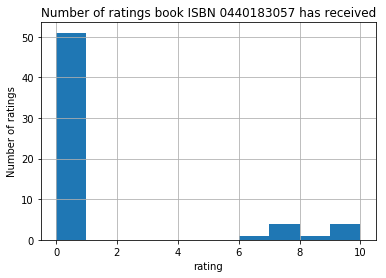

In [54]:
bookUnderReview = "0440183057"
df_new.loc[df_new['ISBN'] == bookUnderReview]['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title(f"Number of ratings book ISBN {bookUnderReview} has received")
plt.show()

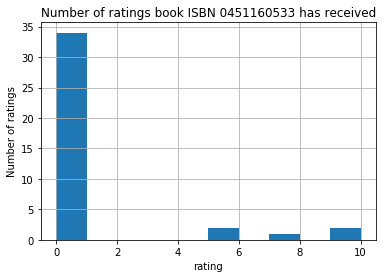

In [55]:
bookUnderReview = "0451160533"
df_new.loc[df_new['ISBN'] == bookUnderReview]['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title(f"Number of ratings book ISBN {bookUnderReview} has received")
plt.show()